### 06. Count the pairs of victimisation experiences and observations.

---
In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a summary table of the victimisation-based mechanism.
PATH_TO_VIC_DATA = "s3://social-research-cheating/summary-tables/emp-net/vic/vic_30.parquet"
vic_data = spark.read.parquet(PATH_TO_VIC_DATA)
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
PATH_TO_OBS_DATA = "s3://social-research-cheating/summary-tables/emp-net/obs/obs_30_5.parquet"
obs_data = spark.read.parquet(PATH_TO_OBS_DATA)
obs_data.registerTempTable("obs_data")

In [3]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

vic_tab.registerTempTable("vic_tab")
obs_tab.registerTempTable("obs_tab")

In [4]:
# Show the first few rows of each dataset.
vic_tab.show(5)
obs_tab.show(5)

# Convert spark dataframes into pandas dataframes.
obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.393b6ee09...|2019-03-08|2019-03-01|     7|        2|            1|           2|
|account.3f888b606...|2019-03-10|2019-03-05|     5|        7|            4|           7|
|account.4b6c650bd...|2019-03-15|2019-03-11|     4|        2|            0|           2|
|account.73e50018a...|2019-03-27|2019-03-20|     7|        1|            1|           1|
|account.b3e7bbe4a...|2019-03-09|2019-03-04|     5|        1|            0|           1|
+--------------------+----------+----------+------+---------+-------------+------------+
only showing top 5 rows

+--------------------+----------+----------+------+---------+-------------+--------------+------------+
|                  id|start_date|    m_date|period|total_obs|total_sev

### 1. Merge two tables.

In [5]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.89e89a88e...|2019-03-08|
|account.14a9052f2...|2019-03-08|
|account.d09650395...|2019-03-10|
|account.8d20619cf...|2019-03-06|
|account.22f135474...|2019-03-07|
|account.826ffb6b1...|2019-03-10|
|account.2ec53847e...|2019-03-11|
|account.72d7c8781...|2019-03-06|
|account.0e6d54c93...|2019-03-05|
|account.ed34dc343...|2019-03-10|
+--------------------+----------+
only showing top 10 rows



In [6]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                            CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.89e89a88e...|2019-03-08|        5|      3|        3|      2|
|account.14a9052f2...|2019-03-08|        8|      3|        6|      3|
|account.d09650395...|2019-03-10|        1|      1|        1|      0|
|account.8d20619cf...|2019-03-06|        1|      1|        0|      0|
|account.22f135474...|2019-03-07|        0|      0|        0|      0|
|account.826ffb6b1...|2019-03-10|        0|      0|        0|      0|
|account.2ec53847e...|2019-03-11|        3|      1|        1|      0|
|account.72d7c8781...|2019-03-06|        3|      1|        0|      0|
|account.0e6d54c93...|2019-03-05|        1|      0|        1|      1|
|account.ed34dc343...|2019-03-10|        0|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

### 2. Plot the distribution of experiences and observations.

In [7]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(pairs_tab.head())
print(pairs_tab.tail())

   total_obs  total_exp  freq
0          0          0   644
1          0          1   180
2          0          2    29
3          0          3    11
4          0          4     1
    total_obs  total_exp  freq
71         19          7     1
72         25          2     1
73         26          2     1
74         27          4     1
75         37          2     1


In [8]:
# Store the dataframe as an excel file.
pairs_tab.to_csv('emp_data.csv', index=False)

In [9]:
merged_tab = merged_df.toPandas()
sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(sev_pairs_tab.head())
print(sev_pairs_tab.tail())

# Store the dataframe as an excel file.
sev_pairs_tab.to_csv('sev_emp_data.csv', index=False)

   total_obs  sev_exp  freq
0          0        0   805
1          0        1    58
2          0        2     4
3          0        3     1
4          1        0   385
    total_obs  sev_exp  freq
55         19        4     1
56         25        1     1
57         26        0     1
58         27        2     1
59         37        0     1


### 3. Create a merged data table for randomised networks.

Put the number of (observations, experiences) into each cell.

In [10]:
for i in range(1, 6):
    # Read a summary table of the victimisation-based mechanism.
    vic_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic/vic_30_" 
                                 + str(i) + ".parquet")
    vic_data.registerTempTable("vic_data")

    # Read a summary table of the observation-based mechanism.
    obs_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/obs/obs_30_5/obs_30_5_" 
                                 + str(i) + ".parquet")
    obs_data.registerTempTable("obs_data")
    
    # Collect the transitions that happened within seven days after observing or being killed by cheating.
    vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
    obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

    vic_tab.registerTempTable("vic_tab")
    obs_tab.registerTempTable("obs_tab")

    obs_df = obs_tab.toPandas()
    vic_df = vic_tab.toPandas()
    
    dates_obs = obs_df[['id', 'start_date']]
    dates_vic = vic_df[['id', 'start_date']]
    dates_df = pd.concat([dates_obs, dates_vic])
    dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
    dates_df = spark.createDataFrame(dates_df)
    dates_df.registerTempTable("dates_df")
    
    add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                                CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                                CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                                FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
    add_obs_info.registerTempTable("add_obs_info")

    merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                             CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                             CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                             FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
    
    merged_tab = merged_df.toPandas()
    
    pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
    pairs_tab.to_csv('rand_data_' + str(i) + '.csv', index=False)
    
    sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")
    sev_pairs_tab.to_csv('sev_rand_data_' + str(i) + '.csv', index=False)

In [11]:
data = pd.read_csv("emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 6):
    rand_dat = pd.read_csv("rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5
0          0          0  644.0  653.0  664.0  644.0  651.0  648.0
1          0          1  180.0  181.0  188.0  183.0  196.0  170.0
2          0          2   29.0   35.0   31.0   31.0   38.0   26.0
3          0          3   11.0    7.0    9.0   12.0    9.0   15.0
4          0          4    1.0    1.0    2.0    4.0    2.0    3.0


In [12]:
merged_df.to_csv('RV_SO_30_8_7.csv', index=False)

In [ ]:
data = pd.read_csv("sev_emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("sev_rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','sev_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 51):
    rand_dat = pd.read_csv("sev_rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','sev_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

In [ ]:
merged_df.to_csv('SV_SO_30_8_7.csv', index=False)

### 4. Create a heatmap.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib
from matplotlib.colors import DivergingNorm
import scipy.stats

In [44]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 12, # Adjust the font size of x and y labels.
    'axes.titlesize': 12,
    'axes.facecolor': 'lightgray',
    'font.size': 8, 
    'legend.fontsize': 6,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [15, 7],
    'font.family': 'serif'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

Plot a heatmap of relaxed experiences and relaxed/strict observations.

In [60]:
merged_df = pd.read_csv('data/RV_SO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  644.0  653.0  664.0  644.0  651.0  648.0  652.0   
1          1          0  330.0  339.0  323.0  337.0  343.0  340.0  318.0   
2          2          0  122.0  122.0  126.0  117.0  112.0  122.0  123.0   
3          3          0   50.0   37.0   52.0   52.0   55.0   46.0   40.0   
4          4          0   26.0   35.0   33.0   25.0   21.0   30.0   28.0   

      R7  ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf  \
0  670.0  ...  636.0  677.0  664.0  647.0  660.0  646.0     654.42  0.351   
1  308.0  ...  328.0  319.0  319.0  354.0  337.0  327.0     334.12  0.425   
2  117.0  ...  127.0  119.0  123.0  117.0  116.0  134.0     120.38  0.582   
3   50.0  ...   54.0   57.0   46.0   41.0   50.0   46.0      48.26  0.635   
4   19.0  ...   21.0   21.0   23.0   22.0   23.0   19.0      23.80  0.718   

     pmf   prob  
0  0.014  0.663  
1  0.021  0.596  
2  0.036  0.453  
3  0.055

In [61]:
piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.663  0.596  0.453  0.420  0.353  0.061  0.240  0.829  0.263   
1          0.528  0.471  0.837  0.253  0.833  0.258  0.652  0.290  0.765   
2          0.643  0.420  0.263  0.057  0.479  0.829  0.704  0.709  0.361   
3          0.273  0.264  0.304  0.946  0.899  0.325  0.436  0.211  0.422   
4          0.924  1.000  0.356  0.705  0.291  1.000  0.738  0.242  0.568   
5          0.100  1.000  1.000  1.000  0.142  1.000  0.405  0.033  0.330   
6          1.000    NaN    NaN  1.000  1.000  1.000  1.000  1.000  0.165   
7          1.000    NaN  1.000    NaN  1.000  1.000  1.000  1.000  1.000   
8            NaN    NaN    NaN    NaN  1.000  1.000    NaN    NaN  1.000   
9            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  1.000   
10           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

total_obs  

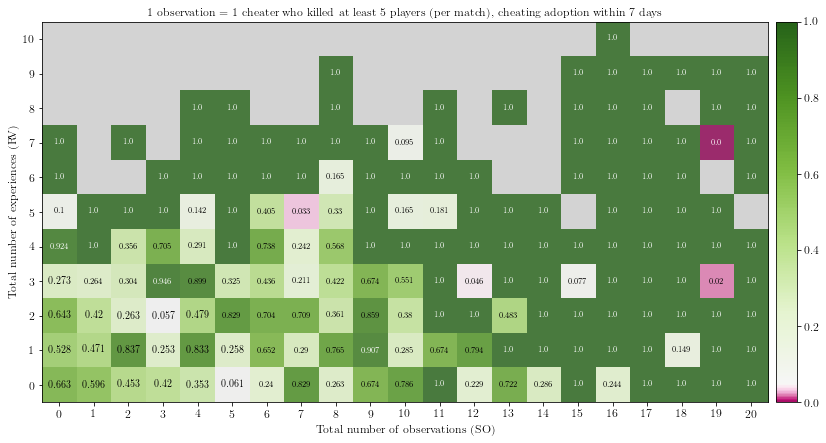

In [62]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["total_exp"], columns=["total_obs"])

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RV)')

textcolors = ["k", "w"]
fontsize = [8, 10]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0],
                           fontsize=fontsize[1 if freq_piv[x][y] >= 10 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/RV_SO_p_vals.png')

Plot a heatmap of strict experiences and relaxed/strict observations.

In [57]:
merged_df = pd.read_csv('data/SV_RO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)

test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  269.0  259.0  269.0  246.0  281.0  254.0  260.0  258.0   
1          1        0  412.0  440.0  427.0  449.0  427.0  433.0  444.0  436.0   
2          2        0  254.0  247.0  244.0  239.0  243.0  255.0  236.0  240.0   
3          3        0  165.0  156.0  167.0  164.0  169.0  155.0  160.0  143.0   
4          4        0  114.0  105.0  115.0  113.0  104.0  122.0  104.0  115.0   

   ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf    pmf  \
0  ...  259.0  256.0  258.0  276.0  268.0  262.0     260.94  0.704  0.021   
1  ...  415.0  420.0  429.0  420.0  426.0  432.0     429.74  0.203  0.014   
2  ...  261.0  258.0  253.0  254.0  251.0  236.0     248.18  0.659  0.023   
3  ...  164.0  177.0  156.0  158.0  168.0  175.0     161.94  0.615  0.030   
4  ...  110.0  104.0  106.0  108.0  105.0  107.0     110.08  0.668  0.035   

    prob  
0  0.317  
1  0.810  
2  0.364  
3  0.4

In [58]:
piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1      2      3      4      5      6      7      8   \
sev_exp                                                                    
0          0.317  0.810  0.364  0.415  0.367  0.803  0.876  0.497  0.743   
1          0.598  0.226  0.461  0.489  0.829  0.214  0.347  0.286  0.191   
2          0.812  1.000  0.381  0.129  0.494  0.275  0.802  0.036  0.853   
3          0.493    NaN    NaN  1.000  1.000  0.077  1.000  0.197  0.012   
4          1.000    NaN    NaN    NaN    NaN    NaN    NaN  1.000  1.000   
5            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

total_obs     9   ...     11     12     13     14     15     16     17     18  \
sev_exp           ...                                                           
0          0.331  ...  0.077  0.620  0.583  0.910  0.397  0.562  0.815  0.492   
1          0.763  ...  0.850  0.779  0.559  0.457  0.402  0.031  0.603  0.636   
2          1.000  ...  0.442  0.674  0.743  1.000  0.469  1.000  1.

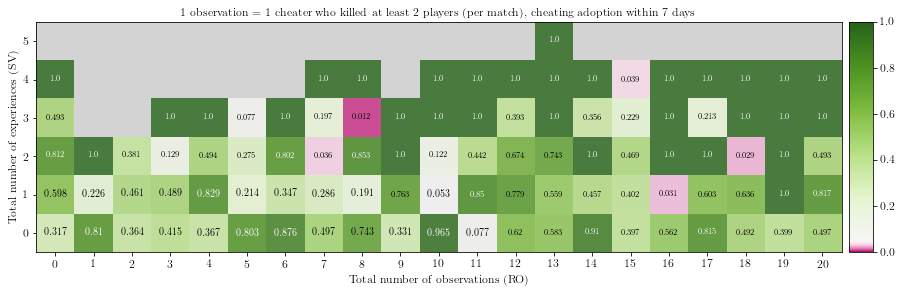

In [59]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]
fontsize = [8, 10]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.8 else 0],
                           fontsize=fontsize[1 if freq_piv[x][y] >= 10 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SV_RO_p_vals.png')

In [64]:
merged_df = pd.read_csv('data/RV_SO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  644.0  653.0  664.0  644.0  651.0  648.0  652.0   
1          1          0  330.0  339.0  323.0  337.0  343.0  340.0  318.0   
2          2          0  122.0  122.0  126.0  117.0  112.0  122.0  123.0   
3          3          0   50.0   37.0   52.0   52.0   55.0   46.0   40.0   
4          4          0   26.0   35.0   33.0   25.0   21.0   30.0   28.0   

      R7  ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf  \
0  670.0  ...  636.0  677.0  664.0  647.0  660.0  646.0     654.42  0.351   
1  308.0  ...  328.0  319.0  319.0  354.0  337.0  327.0     334.12  0.425   
2  117.0  ...  127.0  119.0  123.0  117.0  116.0  134.0     120.38  0.582   
3   50.0  ...   54.0   57.0   46.0   41.0   50.0   46.0      48.26  0.635   
4   19.0  ...   21.0   21.0   23.0   22.0   23.0   19.0      23.80  0.718   

     pmf   prob  
0  0.014  0.663  
1  0.021  0.596  
2  0.036  0.453  
3  0.055

In [67]:
cdf = pd.pivot_table(test_dat, values="cdf",index=["total_exp"], columns=["total_obs"], fill_value=0)
print(cdf)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.351  0.425  0.582  0.635  0.718  0.964  0.859  0.380  0.865   
1          0.501  0.567  0.197  0.795  0.234  0.816  0.519  0.836  0.474   
2          0.427  0.660  0.808  0.966  0.639  0.298  0.507  0.549  0.831   
3          0.820  0.877  0.851  0.158  0.256  0.810  0.775  0.924  0.824   
4          0.271  0.771  0.927  0.655  0.878  0.179  0.613  0.930  0.794   
5          0.974  0.961  0.942  0.819  0.971  0.560  0.904  0.997  0.938   
6          0.771  0.000  0.000  0.923  0.787  0.887  0.803  0.923  0.986   
7          0.980  0.000  0.980  0.000  0.961  0.980  0.942  0.961  0.980   
8          0.000  0.000  0.000  0.000  0.980  0.980  0.000  0.000  0.961   
9          0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.980   
10         0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

total_obs  

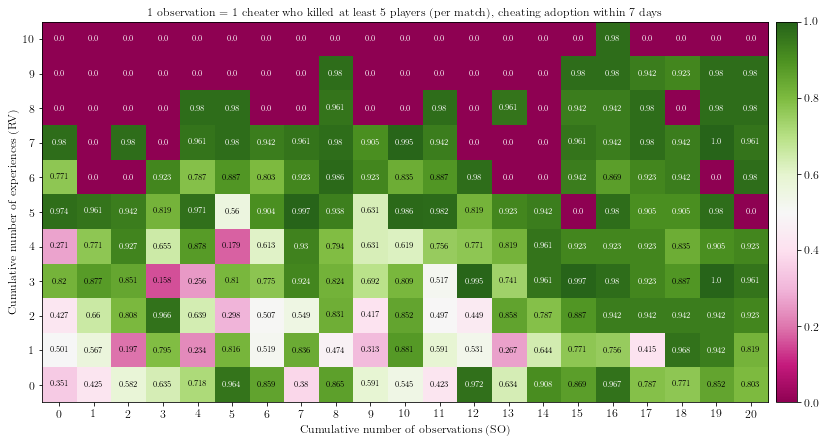

In [69]:
fig, ax = plt.subplots()
norm = DivergingNorm(vmin=0, vcenter=0.5, vmax=1)
img1 = ax.imshow(cdf, norm=norm)
ax.set_xticks(np.arange(cdf.shape[1]))
ax.set_yticks(np.arange(cdf.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Cumulative number of observations (SO)')
plt.ylabel('Cumulative number of experiences (RV)')

textcolors = ["k", "w"]

for y in range(cdf.shape[0]):
    for x in range(cdf.shape[1]):
        if np.isnan(cdf[x][y]) == False:
            text = ax.text(x, y, cdf[x][y], ha="center", va="center",
                           color=textcolors[1 if cdf[x][y] <= 0.1 or cdf[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()

Plot a cumulative frequency heatmap.

In [25]:
arr = np.array(freq)
emp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
print(emp_cumsum)

[[ 644  974 1096 1146 1172 1190 1198 1200 1205 1207 1208 1208 1209 1210
  1212 1212 1213 1213 1213 1213 1213]
 [ 824 1263 1442 1533 1575 1610 1623 1631 1638 1641 1645 1647 1649 1650
  1652 1652 1653 1653 1655 1655 1655]
 [ 853 1315 1513 1624 1677 1717 1733 1743 1753 1757 1763 1765 1767 1769
  1771 1771 1772 1772 1774 1774 1774]
 [ 864 1330 1532 1645 1700 1746 1765 1778 1790 1795 1802 1804 1808 1810
  1812 1813 1814 1814 1816 1817 1817]
 [ 865 1331 1534 1648 1706 1752 1772 1787 1800 1805 1812 1814 1818 1820
  1822 1823 1824 1824 1826 1827 1827]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1809 1814 1822 1825 1829 1831
  1833 1834 1835 1835 1837 1838 1838]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1823 1826 1830 1832
  1834 1835 1836 1836 1838 1839 1839]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1824 1827 1831 1833
  1835 1836 1837 1837 1839 1841 1841]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1824 1827 1831 1833
  1835 1836 1837 1837 1839 1841 1841]]


In [31]:
freq = pd.pivot_table(test_dat, values="R1",index=["total_exp"], columns=["total_obs"], fill_value=0)
print(freq)

arr = np.array(freq)
ran_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
print(ran_cumsum)

for i in range(2, 6):
    freq = pd.pivot_table(test_dat, values="R" + str(i),index=["total_exp"], columns=["total_obs"], fill_value=0)
    arr = np.array(freq)
    temp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
    ran_cumsum += temp_cumsum
    
print(ran_cumsum)

rand_mean = ran_cumsum / 5
cdf_mat = scipy.stats.poisson.cdf(emp_cumsum, rand_mean)
pmf_mat = scipy.stats.poisson.pmf(emp_cumsum, rand_mean)
prob_mat = 1 - cdf_mat + pmf_mat

prob_mat = prob_mat.round(3)
print(prob_mat)

total_obs   0    1    2   3   4   5   6   7   8   9   ...  11  12  13  14  15  \
total_exp                                             ...                       
0          653  339  122  37  35   7   6   3   6   2  ...   0   0   1   0   0   
1          181  111   70  29  19  11   6   3   4   2  ...   3   1   0   1   1   
2           35   23   15  12  15  12   2   2   3   0  ...   0   1   2   1   0   
3            7    3    0   3   4   6   5   2   2   0  ...   1   1   2   0   0   
4            1    1    0   1   2   2   0   1   1   0  ...   0   0   0   0   0   
5            2    0    0   0   2   0   0   1   0   0  ...   0   0   0   0   0   
6            0    0    0   0   0   0   0   0   0   1  ...   0   0   0   0   0   
7            0    0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
8            0    0    0   0   1   0   0   0   0   0  ...   0   0   0   0   0   

total_obs  16  17  18  19  20  
total_exp                      
0           0   0   0   0   1  
1           

In [35]:
cum_piv = pd.DataFrame(data=prob_mat).rename_axis(index='total_exp', columns='total_obs')
print(cum_piv)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.628  0.681  0.647  0.626  0.655  0.568  0.543  0.550  0.536   
1          0.660  0.648  0.681  0.546  0.633  0.505  0.499  0.480  0.489   
2          0.697  0.696  0.697  0.509  0.586  0.486  0.494  0.476  0.475   
3          0.689  0.674  0.659  0.493  0.578  0.463  0.480  0.441  0.437   
4          0.705  0.690  0.670  0.503  0.587  0.492  0.511  0.458  0.452   
5          0.676  0.666  0.648  0.482  0.563  0.467  0.484  0.417  0.406   
6          0.676  0.666  0.648  0.482  0.563  0.467  0.484  0.419  0.403   
7          0.676  0.666  0.648  0.482  0.565  0.471  0.488  0.423  0.406   
8          0.676  0.666  0.648  0.482  0.566  0.473  0.490  0.424  0.408   

total_obs     9   ...     11     12     13     14     15     16     17     18  \
total_exp         ...                                                           
0

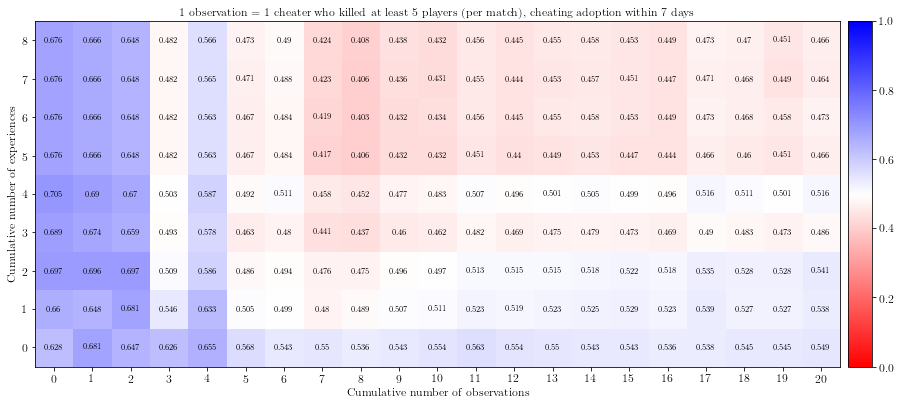

In [43]:
fig, ax = plt.subplots()
norm = DivergingNorm(vmin=0, vcenter=0.5, vmax=1)
img1 = ax.imshow(cum_piv, norm=norm)
ax.set_xticks(np.arange(cum_piv.shape[1]))
ax.set_yticks(np.arange(cum_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Cumulative number of observations')
plt.ylabel('Cumulative number of experiences')

textcolors = ["k", "w"]

for y in range(cum_piv.shape[0]):
    for x in range(cum_piv.shape[1]):
        if np.isnan(cum_piv[x][y]) == False:
            text = ax.text(x, y, cum_piv[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_piv[x][y] <= 0.1 or cum_piv[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/cum_cnt_p_vals.png')